# Supervised Autoencoder

## 1) MODEL 1 vect pca umap
### a) Random Forest
### b) DNN
## 2) MODEL 2 vect pca autoencoder umap
### a) Random Forest
### b) DNN
## 3) MODEL 3 vect pca SUP-autoencoder(high_low) umap
### a) Random Forest
### b) DNN
## 4) MODEL 4 vect pca SUP-autoencoder(sinusoidal) umap
### a) Random Forest
### b) DNN

In [3]:
import numpy as np
from eden import graph
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import matplotlib
import umap
import utilities

from evaluator import Evaluator
from sklearn.neighbors import KNeighborsClassifier
import sklearn as sk
from sklearn.model_selection import train_test_split

from embedder import Transformer_RF_umap
from embedder import Transformer_DNN_umap

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# Load dataset 624249 

In [4]:
import networkx as nx
def load_generated_data_classification(path):
    
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    
    labels = list(np.load(path+'/'+'labels.npy'))
    
    _, count = np.unique(labels,return_counts=True)
    
    print("Negative samples: ",count[0])
    print("Positive samples: ",count[1])
    
    return (graphs,labels)

def sub_sample_classification(graphs,labels, n_graphs):
    
    graphs, labels = sk.utils.shuffle(graphs, labels)
    return (graphs[0:n_graphs],labels[0:n_graphs])

In [5]:
graphs, labels = load_generated_data_classification("generate_graphs/624249_pos_neg")

Negative samples:  136
Positive samples:  256


In [6]:
#graphs, labels = sub_sample_classification(graphs,labels,1000)

In [7]:
# prepross 
for g in graphs:
    for node in g.nodes():
        g.nodes[node]['vec'] = []
for g in graphs:
    for edge in g.edges():
        g.edges[edge]['vec'] = []

In [8]:
graphs_train,graphs_test,labels_train,labels_test = train_test_split(graphs,labels,test_size=0.3)

In [9]:
print(len(graphs_train))

274


In [10]:
vectoriz = graph.Vectorizer(complexity = 5)
data_train = vectoriz.transform(graphs_train)
data_test = vectoriz.transform(graphs_test)

# MODEL 1: Vect PCA_500 UMAP_2
## (Random Forest) - (DNN)

In [11]:
pca_1 = TruncatedSVD(n_components=500)
res_pca_train = pca_1.fit(data_train).transform(data_train)
res_pca_test = pca_1.transform(data_test)

evaluate(res_pca_test,labels_test,res_pca_train,labels_train)

DIM: 274            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.702    0.767


## (Random Forest)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.686    0.679


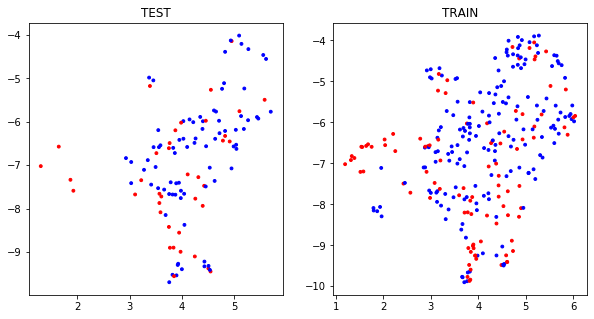

In [12]:
res_2d_test, res_2d_train = from_emb_to_2D_RF(res_pca_train,labels_train,res_pca_test)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

## (DNN)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.558     0.95


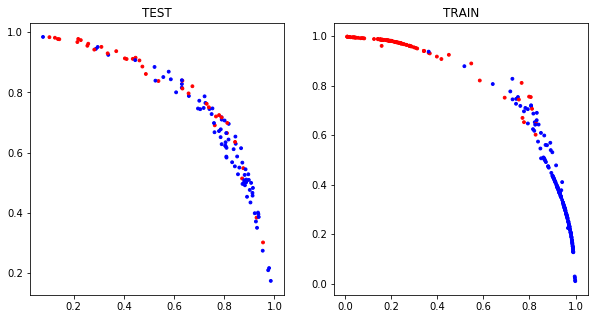

In [13]:
dim_input = len(res_pca_train[0])
res_2d_test, res_2d_train = from_emb_to_2D_DNN(res_pca_train,labels_train,res_pca_test,dim_input)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

# MODEL2: Vect -- PCA_500 -- AUTOENCODER_60 -- UMAP 2
## (Random Forest) -- (DNN)

In [14]:
from keras.layers import Dropout
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from embedder import Preprocessing_scaler
from sklearn.preprocessing import Normalizer

In [15]:
m2_data_test,m2_data_train = pca_scale_normalize(data_test,data_train)

In [16]:
input_auto = len(m2_data_test[0])
print(input_auto)

274


In [17]:
autoencoder,encoder = gen_simple_auto(input_auto,60)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
er = EarlyStopping(monitor='val_loss', patience=700, restore_best_weights=True)

autoencoder.fit(m2_data_train,m2_data_train,
                epochs=2500,
                verbose = 0,
                batch_size = 32,
                validation_split = 0.2,
                callbacks=[er])

print(autoencoder.evaluate(m2_data_test,m2_data_test))
print("stopped epoch: ",er.stopped_epoch)

118/118 [==============================] - 0s 218us/step
5.64251096289747e-05
stopped epoch:  0


In [19]:
pred_test = autoencoder.predict(m2_data_test)
pred_train = autoencoder.predict(m2_data_train)

#plot_auto(pred_test,m2_data_test,pred_train,m2_data_train)

In [20]:
res_auto_train = encoder.predict(m2_data_train)
res_auto_test = encoder.predict(m2_data_test)

In [21]:
evaluate(res_auto_test,labels_test,res_auto_train,labels_train)

DIM: 60             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.586    0.693


## (Random Forest)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.599    0.652


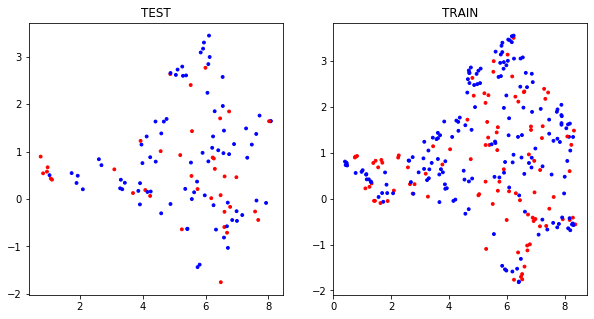

In [22]:
res_2d_test, res_2d_train = from_emb_to_2D_RF(res_auto_train,labels_train,res_auto_test)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

## (DNN)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.552    0.595


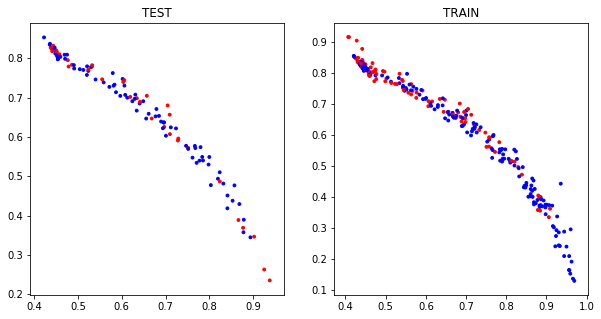

In [23]:
dim_input = len(res_auto_train[0])
res_2d_test, res_2d_train = from_emb_to_2D_DNN(res_auto_train,labels_train,res_auto_test,dim_input)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

# MODEL3: Vect -- PCA_500 -- SUPERVISED_AUTOENCODER  -- UMAP 2
## Callback highLow 
## (Random Forest) -- (DNN)

In [24]:
from my_callbacks import MyCallback_low_high

In [25]:
m3_data_test,m3_data_train  = pca_scale_normalize(data_test,data_train)
input_auto = len(m3_data_test[0])

In [26]:
w_dec = K.variable(1)
w_cla = K.variable(1)
autoencoder,encoder =  generate_supervised_autoencoder_callback(w_dec,w_cla,
                                                                input_auto=input_auto,
                                                                embedding_size=50)
# convert to categorical
y_train = utilities.from_np_to_one_hot(labels_train)
y_test = utilities.from_np_to_one_hot(labels_test)

In [27]:
epochs = 200
my = MyCallback_low_high(w_dec,w_cla,epochs,l_period=50)

h = autoencoder.fit(m3_data_train,
                    {'decoder': m3_data_train, 'classifier': y_train},
                    epochs=epochs,  
                    batch_size=32,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[my])

a = autoencoder.evaluate(m3_data_test,[m3_data_test,y_test])
n = autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 219us/step
loss 0.5550572680214704
decoder_loss 0.0021296682712322068
classifier_loss 0.5550572680214704
decoder_mean_squared_error 0.0021296682712322068
classifier_acc 0.7542372891458414


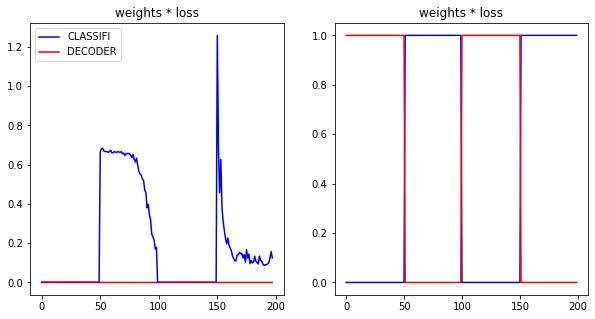

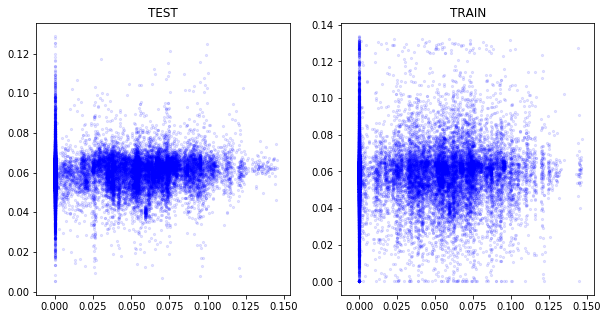

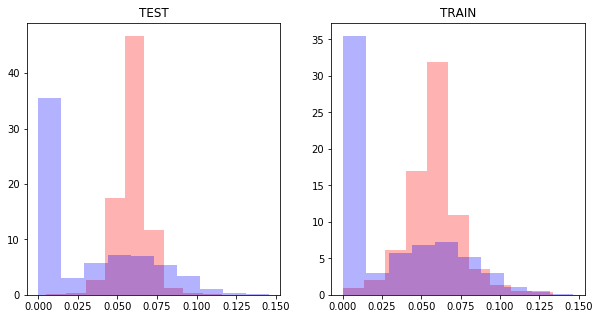

In [28]:
#### EVALUATE AUTOENCODER
plot_loss(my,h)
pred_test = autoencoder.predict(m3_data_test)[0]
pred_train = autoencoder.predict(m3_data_train)[0]
plot_auto(pred_test,m3_data_test,pred_train,m3_data_train)

In [30]:
res_auto_train = encoder.predict(m3_data_train)
res_auto_test = encoder.predict(m3_data_test)
evaluate(res_auto_test,y_test,res_auto_train,y_train)

DIM: 50             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.718    0.908


## (Random Forest)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.727    0.909


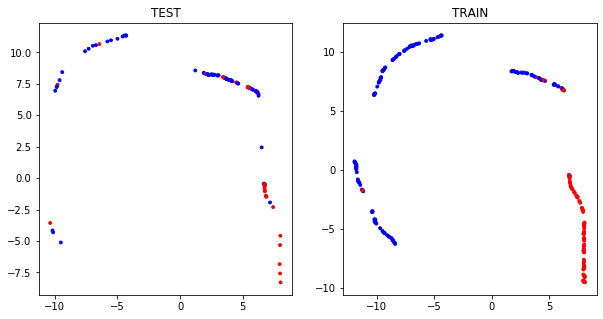

In [31]:
res_2d_test, res_2d_train = from_emb_to_2D_RF(res_auto_train,labels_train,res_auto_test)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

## (DNN)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.677    0.865


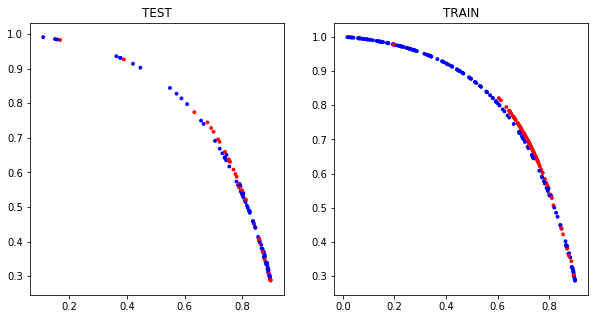

In [32]:
dim_input = len(res_auto_train[0])
res_2d_test, res_2d_train = from_emb_to_2D_DNN(res_auto_train,labels_train,res_auto_test,dim_input)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

# MODEL4: Vect -- PCA_500 -- SUPERVISED_AUTOENCODER  -- UMAP 2
## Callback sinusoidal 
## (Random Forest) -- (DNN)

In [48]:
from my_callbacks import MyCallback_sinusoidal

In [49]:
m4_data_test,m4_data_train  = pca_scale_normalize(data_test,data_train)
input_auto = len(m4_data_test[0])

In [50]:
w_dec = K.variable(1)
w_cla = K.variable(1)
autoencoder,encoder =  generate_supervised_autoencoder_callback(w_dec,w_cla,
                                                                input_auto=input_auto,
                                                                embedding_size=20)
# convert to categorical
y_train = utilities.from_np_to_one_hot(labels_train)
y_test = utilities.from_np_to_one_hot(labels_test)

In [51]:
epochs = 300
plateau = 5
k = 1
n_period = 6
scale_c = 0.01
scale_d = 0.9

my = MyCallback_sinusoidal(w_dec,w_cla,epochs,plateau,k,n_period,scale_c,scale_d)

h = autoencoder.fit(m4_data_train,
                    {'decoder': m4_data_train, 'classifier': y_train},
                    epochs=epochs,  
                    batch_size=32,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[my])

a = autoencoder.evaluate(m4_data_test,[m4_data_test,y_test])
n = autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 224us/step
loss 0.004144112950475034
decoder_loss 0.0010047208249442659
classifier_loss 0.7075663441318577
decoder_mean_squared_error 0.0010047208249442659
classifier_acc 0.8050847498037047


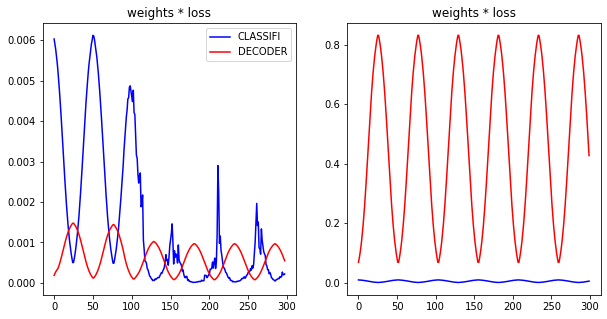

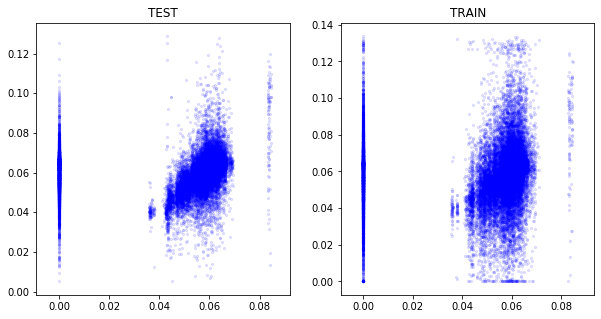

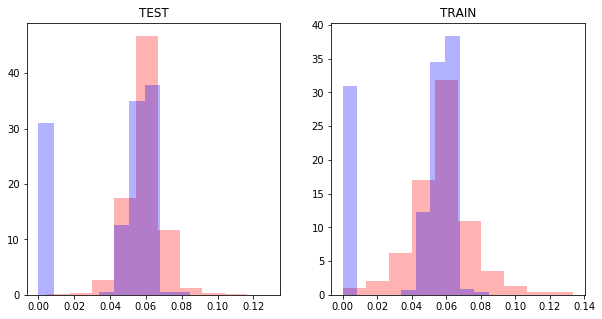

In [52]:
#### EVALUATE AUTOENCODER
plot_loss(my,h)
pred_test = autoencoder.predict(m3_data_test)[0]
pred_train = autoencoder.predict(m3_data_train)[0]
plot_auto(pred_test,m3_data_test,pred_train,m3_data_train)

In [53]:
res_auto_train = encoder.predict(m3_data_train)
res_auto_test = encoder.predict(m3_data_test)
evaluate(res_auto_test,y_test,res_auto_train,y_train)

DIM: 20             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.719    0.937


## (Random Forest)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.688    0.951


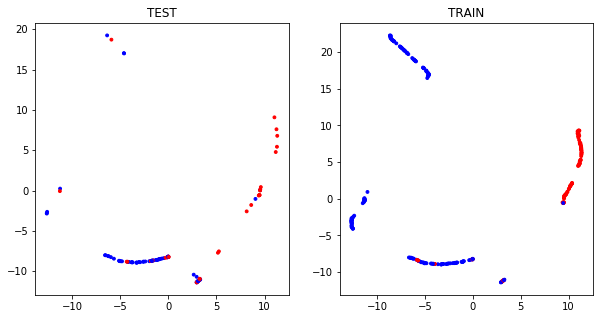

In [54]:
res_2d_test, res_2d_train = from_emb_to_2D_RF(res_auto_train,labels_train,res_auto_test)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

## (DNN)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.711    0.917


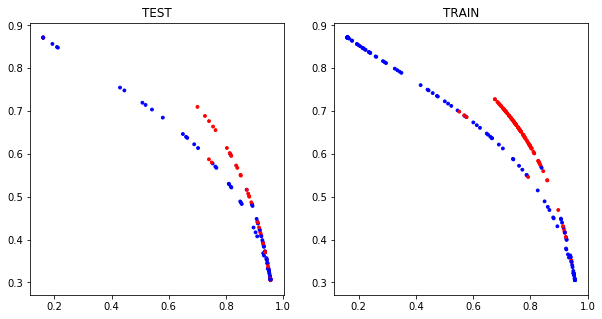

In [55]:
dim_input = len(res_auto_train[0])
res_2d_test, res_2d_train = from_emb_to_2D_DNN(res_auto_train,labels_train,res_auto_test,dim_input)

evaluate(res_2d_test,labels_test,res_2d_train,labels_train)
plot_embedding(res_2d_test,labels_test,res_2d_train,labels_train)

# TO USE

In [1]:
from embedder import Preprocessing_scaler
from sklearn.preprocessing import Normalizer
from keras import callbacks
import math
from keras import backend as K
from tabulate import tabulate


from keras import Input
from keras.layers import Dense, Dropout
from keras import Model
from keras.initializers import RandomNormal
from keras.losses import mean_squared_error


def gen_simple_auto(input_auto,dim_embeddig):
    iniz = RandomNormal(mean=0, stddev=0.05)
    rate_drop = 0.8

    x_in = Input(shape=(input_auto,))
    enc = Dense(input_auto * 2, activation="relu",kernel_initializer=iniz)(x_in)
    enc = Dropout(rate = rate_drop)(enc)
    enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
    enc = Dropout(rate = 0.5)(enc)
    enc = Dense(dim_embeddig, activation="sigmoid",kernel_initializer=iniz)(enc)

    dec = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)

    autoencoder = Model(x_in, dec)
    autoencoder.compile(optimizer='adam', loss=mean_squared_error)
    
    encoder = Model(x_in, enc)
    
    return (autoencoder,encoder)

def pca_scale_normalize(data_test,data_train):
    pca = TruncatedSVD(n_components=500)
    pca_train = pca.fit(data_train).transform(data_train)
    pca_test = pca.transform(data_test)
    
    # SCALER
    scaler = Preprocessing_scaler([0, 1])
    scal_train = scaler.fit(pca_train).transform(pca_train)
    scal_test = scaler.transform(pca_test)
    
    # NORMALIZER
    normalizer = Normalizer(copy=True, norm='l2')  
    norm_train = normalizer.fit(scal_train).transform(scal_train)
    norm_test = normalizer.transform(scal_test)
    
    
    return(norm_test,norm_train)


def from_emb_to_2D_RF(emb_train,y_train,emb_test):
    uma = umap.UMAP(n_components=2, random_state=10)
    rf_umap = Transformer_RF_umap(uma)

    rf_umap.fit(emb_train,utilities.from_one_hot_to_np(y_train))
    res_test = rf_umap.transform(emb_test)
    res_train = rf_umap.transform(emb_train)
    
    return(res_test,res_train)

def from_emb_to_2D_DNN(emb_train,y_train,emb_test,size_emb_encod):
    x_in = Input(shape=(size_emb_encod,))
    den = Dense(int(size_emb_encod/2),activation="relu")(x_in)
    den = Dense(int(size_emb_encod/4),activation="relu")(den)
    den = Dense(2,activation="sigmoid")(den)

    dnn = Model(x_in,den)
    dnn.compile(optimizer="adam",loss=mean_squared_error)

    uma = umap.UMAP(n_components=2)

    tran_DNN_umap = Transformer_DNN_umap(dnn,uma,epochs=500,batch_size=32)
    tran_DNN_umap.fit(emb_train,y_train)

    res_2d_train = tran_DNN_umap.transform(emb_train)
    res_2d_test = tran_DNN_umap.transform(emb_test)
    
    return(res_2d_test,res_2d_train)


def plot_loss(my,h):
    clas = my.w_clas
    clal = h.history['classifier_loss']

    dec = my.w_decs
    decl = h.history['decoder_loss']

    c = []
    d = []

    for i in range(len(dec)):
        c.append(clas[i]*clal[i])
        d.append(dec[i]*decl[i])

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("weights * loss")
    plt.plot(c[1:-1],label="CLASSIFI",c = 'b')
    plt.plot(d[1:-1],label="DECODER", c="r")
    plt.legend()

    plt.subplot(122)
    plt.title("weights * loss")
    plt.plot(my.w_clas,label="CLASSIFI",c = 'b')
    plt.plot(my.w_decs,label="DECODER", c="r")
    
    plt.show()


def evaluate(emb_test,y_test,emb_train,y_train):
    dim = len(emb_test[0])
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc_test, _,_,_ = eva.performance_with_kfold(emb_test,y_test)
    acc_test = "%.3f" % np.mean(acc_test)
    
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc_train, _,_,_ = eva.performance_with_kfold(emb_train,y_train)
    acc_train = "%.3f" % np.mean(acc_train)
    
    print (tabulate([['K.N.N.  accuracy', acc_test, acc_train]], headers=["DIM: "+str(dim), 'TEST','TRAIN']))
    
    


def generate_supervised_autoencoder_callback(w_dec,w_cla,input_auto,embedding_size=32):

    iniz = RandomNormal(mean=0, stddev=0.05)
    
    prob_drop = 0.5
    x_in = Input(shape=(input_auto,))
    enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
    enc = Dropout(prob_drop)(enc)
    enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
    enc = Dense(embedding_size, activation="sigmoid",kernel_initializer=iniz)(enc)

    decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

    cla = Dense(10, activation='relu', name='cla_10')(enc)
    cla = Dense(2, activation='softmax',name='classifier')(cla)

    
    encoder = Model(x_in,enc)
    autoencoder = Model(inputs = x_in, outputs = [decode,cla])
    autoencoder.compile(optimizer='adam',
                                metrics={'decoder': 'mse', 'classifier': ['acc']},
                                loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                                loss_weights = {'decoder': w_dec, 'classifier': w_cla})
    return(autoencoder,encoder)

def plot_embedding(res_test,labels_test,res_train,labels_train):

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST")
    plt.scatter(x,y,s=8,c=labels_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN")
    plt.scatter(x,y,s=8,c=labels_train,cmap=matplotlib.colors.ListedColormap(colors))
    
    plt.show()

def pca_scale_normalize(data_test,data_train):
    pca = TruncatedSVD(n_components=500)
    pca_train = pca.fit(data_train).transform(data_train)
    pca_test = pca.transform(data_test)
    
    # SCALER
    scaler = Preprocessing_scaler([0, 1])
    scal_train = scaler.fit(pca_train).transform(pca_train)
    scal_test = scaler.transform(pca_test)
    
    # NORMALIZER
    normalizer = Normalizer(copy=True, norm='l2')  
    norm_train = normalizer.fit(scal_train).transform(scal_train)
    norm_test = normalizer.transform(scal_test)
    
    
    return(norm_test,norm_train)


def plot_auto(pred_test,data_test,pred_train,data_train):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("TEST")
    for i in range(0,100):
        a = pred_test[i]
        b = data_test[i]
        plt.scatter(a,b,s=5,c='b',alpha=0.1)

    plt.subplot(122)
    plt.title("TRAIN")
    for i in range(0,100):
        a = pred_train[i]
        b = data_train[i]
        plt.scatter(a,b,s=5,c='b',alpha=0.1)
        

    tmp = []

    for a in data_test:
        for b in a:
            tmp.append(b)

    tmp_2 = []
    for a in pred_test:
        for b in a:
            tmp_2.append(b)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("TEST")
    plt.hist(tmp,alpha=0.3,color='red',bins=10,density=True)
    plt.hist(tmp_2,alpha=0.3,color='blue', bins=10,density=True)
    tmp = []

    for a in data_train:
        for b in a:
            tmp.append(b)

    tmp_2 = []
    for a in pred_train:
        for b in a:
            tmp_2.append(b)

    plt.subplot(122)
    plt.title("TRAIN")
    plt.hist(tmp,alpha=0.3,color='red',bins=10,density=True)
    plt.hist(tmp_2,alpha=0.3,color='blue', bins=10,density=True)

    plt.show()

Using TensorFlow backend.
